In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

2025-09-08 17:08:36.267881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 17:08:36.268179: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 17:08:36.305021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0


2025-09-08 17:08:37.333662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 17:08:37.334040: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
df = pd.read_csv('Tesla.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset Shape: (1692, 7)

First 5 rows:
        Date       Open   High        Low      Close    Volume  Adj Close
0 2010-06-29  19.000000  25.00  17.540001  23.889999  18766300  23.889999
1 2010-06-30  25.790001  30.42  23.299999  23.830000  17187100  23.830000
2 2010-07-01  25.000000  25.92  20.270000  21.959999   8218800  21.959999
3 2010-07-02  23.000000  23.10  18.709999  19.200001   5139800  19.200001
4 2010-07-06  20.000000  20.00  15.830000  16.110001   6866900  16.110001

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1692 non-null   datetime64[ns]
 1   Open       1692 non-null   float64       
 2   High       1692 non-null   float64       
 3   Low        1692 non-null   float64       
 4   Close      1692 non-null   float64       
 5   Volume     1692 non-null   int64         
 6   Adj Close  169

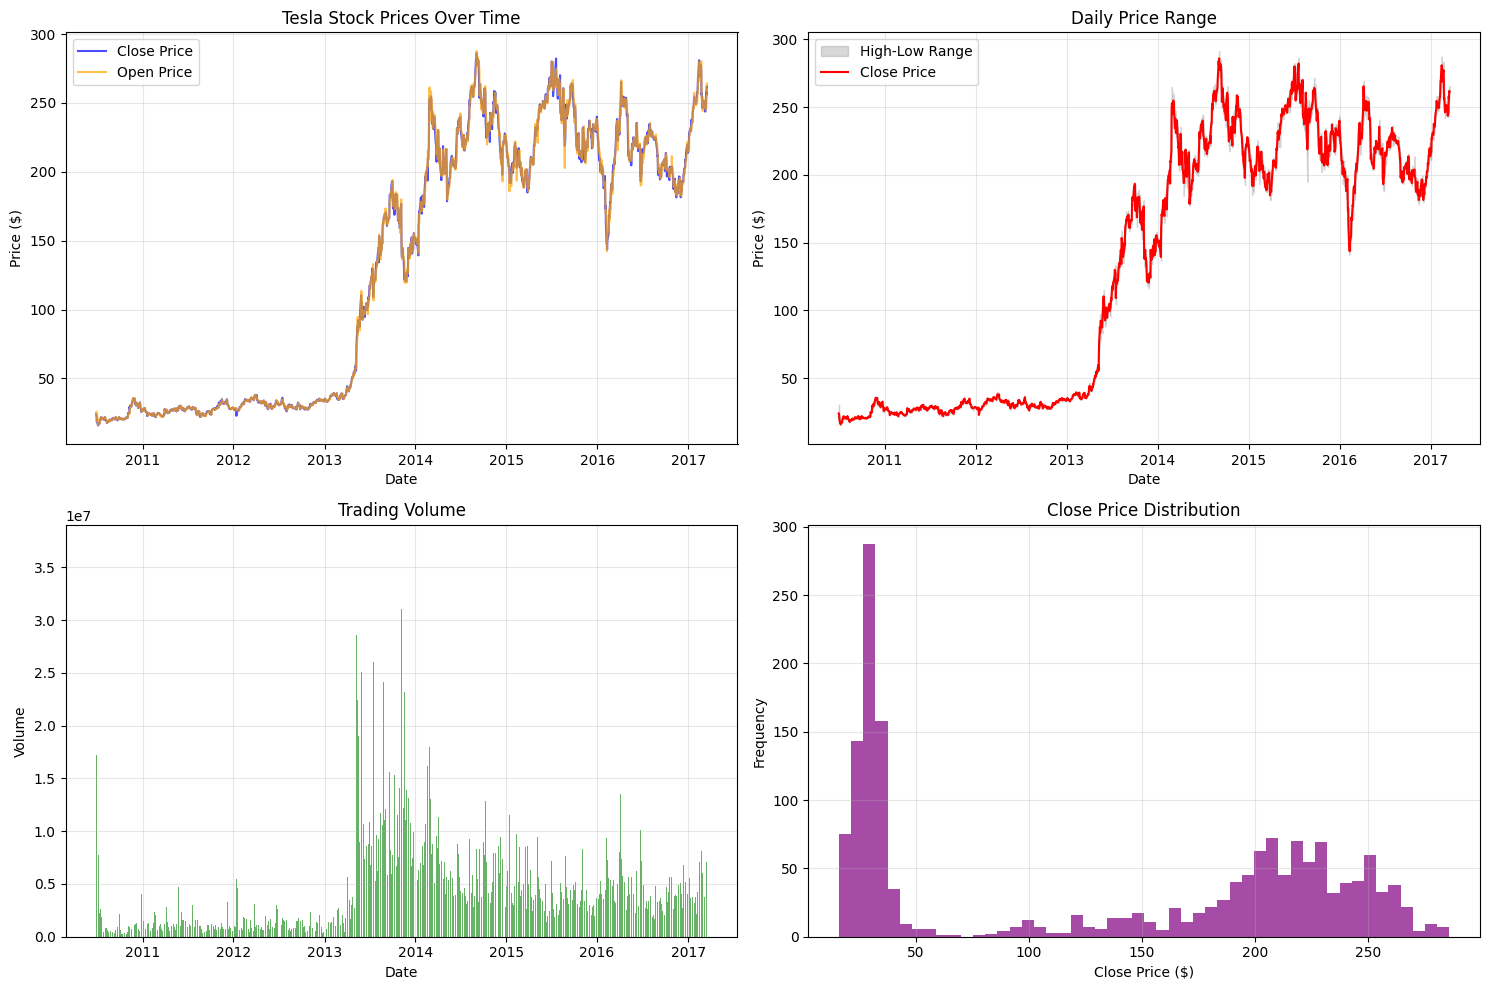


Daily Return Statistics:
Mean Daily Return: 0.0020
Volatility (Std): 0.0329
Min Daily Return: -0.1933
Max Daily Return: 0.2440


In [3]:
# Visualize the Tesla stock data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price trends
axes[0,0].plot(df['Date'], df['Close'], label='Close Price', color='blue', alpha=0.7)
axes[0,0].plot(df['Date'], df['Open'], label='Open Price', color='orange', alpha=0.7)
axes[0,0].set_title('Tesla Stock Prices Over Time')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# High-Low spread
axes[0,1].fill_between(df['Date'], df['Low'], df['High'], alpha=0.3, color='gray', label='High-Low Range')
axes[0,1].plot(df['Date'], df['Close'], color='red', label='Close Price')
axes[0,1].set_title('Daily Price Range')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Price ($)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Volume
axes[1,0].bar(df['Date'], df['Volume'], alpha=0.6, color='green', width=1)
axes[1,0].set_title('Trading Volume')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Volume')
axes[1,0].grid(True, alpha=0.3)

# Price distribution
axes[1,1].hist(df['Close'], bins=50, alpha=0.7, color='purple')
axes[1,1].set_title('Close Price Distribution')
axes[1,1].set_xlabel('Close Price ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate daily returns for additional insights
df['Daily_Return'] = df['Close'].pct_change()
print(f"\nDaily Return Statistics:")
print(f"Mean Daily Return: {df['Daily_Return'].mean():.4f}")
print(f"Volatility (Std): {df['Daily_Return'].std():.4f}")
print(f"Min Daily Return: {df['Daily_Return'].min():.4f}")
print(f"Max Daily Return: {df['Daily_Return'].max():.4f}")

In [4]:
def create_sequences(data, sequence_length):
    """
    Create input sequences for time series prediction
    
    Args:
        data: Scaled time series data
        sequence_length: Number of time steps to look back
    
    Returns:
        X: Input sequences
        y: Target values (next day's opening price)
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # Predict next day's opening price (index 0)
    
    return np.array(X), np.array(y)

# Select features for modeling
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[feature_columns].values

print("Original data shape:", data.shape)
print("Feature columns:", feature_columns)

# Feature Scaling - Critical for RNN/LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("\nData scaling completed!")
print("Scaled data range - Min:", scaled_data.min(), "Max:", scaled_data.max())

# Define sequence parameters
SEQUENCE_LENGTH = 30  # Use 30 days to predict next day
TEST_SIZE = 0.2

# Calculate split index (important: no shuffling for time series!)
split_index = int(len(scaled_data) * (1 - TEST_SIZE))

# Split data chronologically (maintaining temporal order)
train_data = scaled_data[:split_index]
test_data = scaled_data[split_index:]

print(f"\nData split:")
print(f"Training data: {train_data.shape[0]} samples")
print(f"Test data: {test_data.shape[0]} samples")
print(f"Split date: {df.iloc[split_index]['Date']}")

# Create sequences for training
X_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

print(f"\nSequence shapes:")
print(f"X_train: {X_train.shape} (samples, timesteps, features)")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Save scaler for later inverse transformation
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Original data shape: (1692, 5)
Feature columns: ['Open', 'High', 'Low', 'Close', 'Volume']

Data scaling completed!
Scaled data range - Min: 0.0 Max: 1.0

Data split:
Training data: 1353 samples
Test data: 339 samples
Split date: 2015-11-11 00:00:00

Sequence shapes:
X_train: (1323, 30, 5) (samples, timesteps, features)
y_train: (1323,)
X_test: (309, 30, 5)
y_test: (309,)


In [5]:
def create_simplernn_model(input_shape):
    """Create SimpleRNN model architecture"""
    model = Sequential([
        SimpleRNN(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Output: next day's opening price
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_lstm_model(input_shape):
    """Create LSTM model architecture"""
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Output: next day's opening price
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Input shape: (timesteps, features)
input_shape = (SEQUENCE_LENGTH, len(feature_columns))
print("Input shape for models:", input_shape)

# Create models
print("\nBuilding SimpleRNN model...")
rnn_model = create_simplernn_model(input_shape)
print(rnn_model.summary())

print("\nBuilding LSTM model...")
lstm_model = create_lstm_model(input_shape)
print(lstm_model.summary())

# Training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

callbacks = [early_stopping, reduce_lr]

Input shape for models: (30, 5)

Building SimpleRNN model...


2025-09-08 17:12:30.951091: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,151 (35.75 KB)

 Trainable params: 9,151 (35.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

None


Training SimpleRNN model...
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0528 - mae: 0.1580 - val_loss: 0.0412 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - mae: 0.0876 - val_loss: 0.0052 - val_mae: 0.0637 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mae: 0.0632 - val_loss: 0.0013 - val_mae: 0.0279 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0087 - mae: 0.0598 - val_loss: 0.0021 - val_mae: 0.0367 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - mae: 0.0523 - val_loss: 0.0043 - val_mae: 0.0591 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mae: 0.0502 - val_loss: 0.0033 - val_mae: 0.0513 - learning_rate: 0.0010
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mae: 0.0474 - val_loss: 0.0202 - val_mae: 0.1387 - learning_r

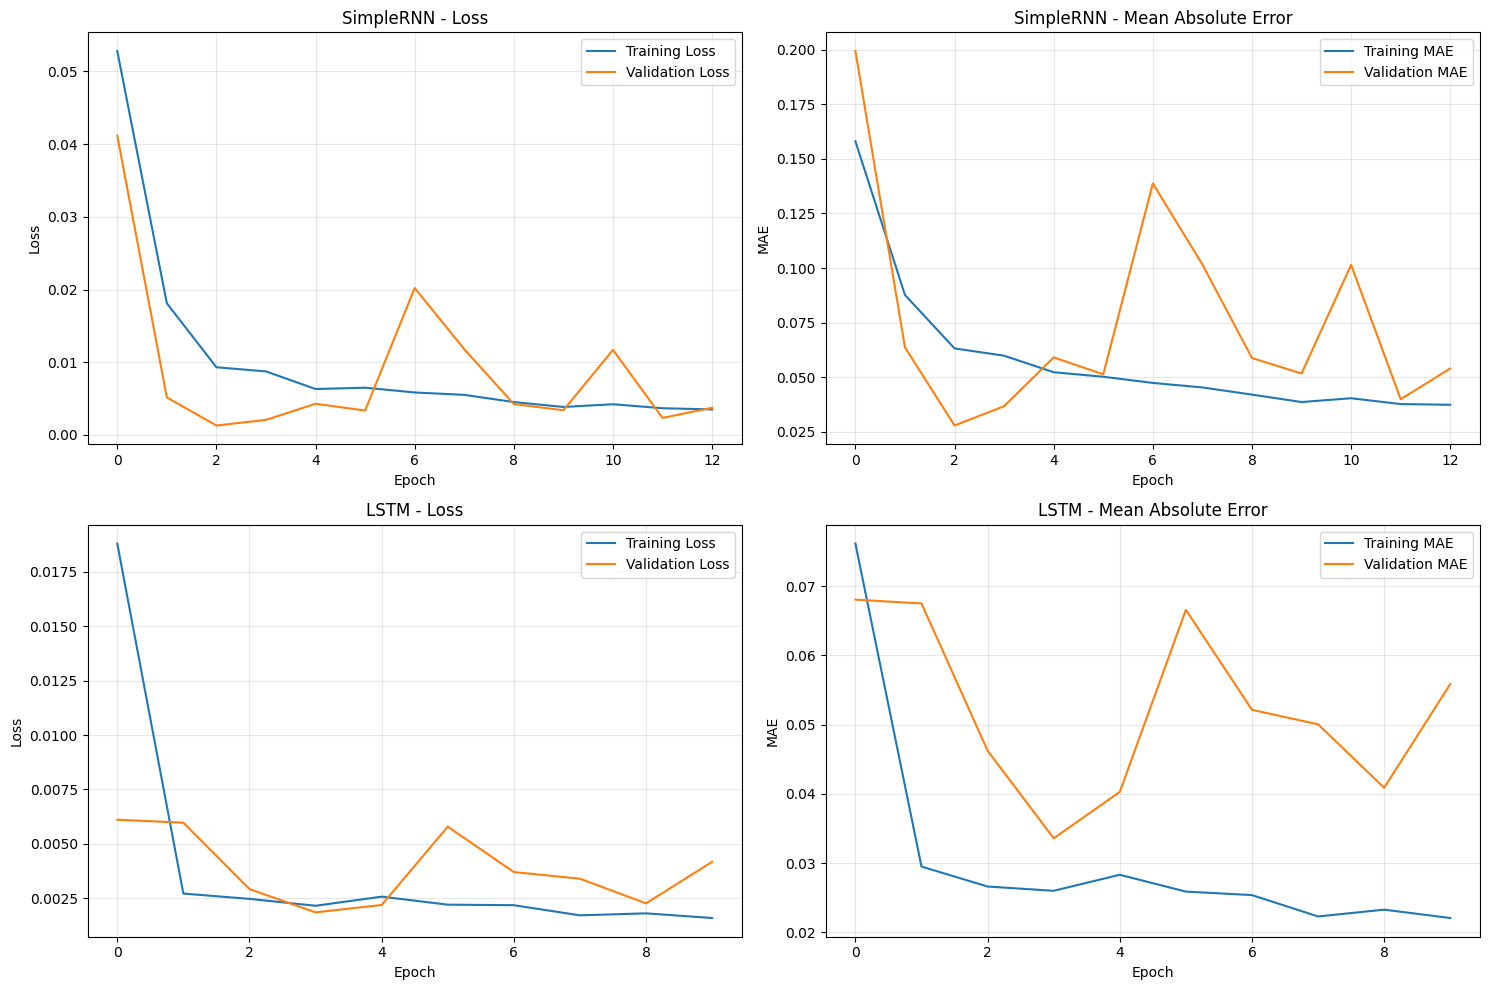

In [6]:
print("Training SimpleRNN model...")
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# SimpleRNN training curves
axes[0,0].plot(rnn_history.history['loss'], label='Training Loss')
axes[0,0].plot(rnn_history.history['val_loss'], label='Validation Loss')
axes[0,0].set_title('SimpleRNN - Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(rnn_history.history['mae'], label='Training MAE')
axes[0,1].plot(rnn_history.history['val_mae'], label='Validation MAE')
axes[0,1].set_title('SimpleRNN - Mean Absolute Error')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('MAE')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# LSTM training curves
axes[1,0].plot(lstm_history.history['loss'], label='Training Loss')
axes[1,0].plot(lstm_history.history['val_loss'], label='Validation Loss')
axes[1,0].set_title('LSTM - Loss')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(lstm_history.history['mae'], label='Training MAE')
axes[1,1].plot(lstm_history.history['val_mae'], label='Validation MAE')
axes[1,1].set_title('LSTM - Mean Absolute Error')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('MAE')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
def evaluate_model(model, X_test, y_test, model_name, scaler):
    """
    Evaluate model performance with comprehensive metrics
    """
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    # Create dummy array for inverse scaling
    dummy_array = np.zeros((len(y_pred_scaled), scaler.n_features_in_))
    dummy_array[:, 0] = y_pred_scaled.flatten()
    y_pred = scaler.inverse_transform(dummy_array)[:, 0]
    
    dummy_array = np.zeros((len(y_test), scaler.n_features_in_))
    dummy_array[:, 0] = y_test
    y_actual = scaler.inverse_transform(dummy_array)[:, 0]
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)
    
    # Calculate percentage metrics
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    
    print(f"\n{model_name} Model Performance:")
    print("="*50)
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return y_pred, y_actual, {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# Evaluate both models
rnn_pred, y_actual, rnn_metrics = evaluate_model(rnn_model, X_test, y_test, "SimpleRNN", scaler)
lstm_pred, _, lstm_metrics = evaluate_model(lstm_model, X_test, y_test, "LSTM", scaler)

# Compare models
print("\nModel Comparison:")
print("="*50)
comparison_df = pd.DataFrame({
    'SimpleRNN': [rnn_metrics['MAE'], rnn_metrics['RMSE'], rnn_metrics['R2'], rnn_metrics['MAPE']],
    'LSTM': [lstm_metrics['MAE'], lstm_metrics['RMSE'], lstm_metrics['R2'], lstm_metrics['MAPE']]
}, index=['MAE ($)', 'RMSE ($)', 'R² Score', 'MAPE (%)'])

print(comparison_df)

# Determine best model
if lstm_metrics['RMSE'] < rnn_metrics['RMSE']:
    print(f"\nLSTM performs better with RMSE: ${lstm_metrics['RMSE']:.2f}")
    best_model = "LSTM"
    best_pred = lstm_pred
else:
    print(f"\nSimpleRNN performs better with RMSE: ${rnn_metrics['RMSE']:.2f}")
    best_model = "SimpleRNN"
    best_pred = rnn_pred

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

SimpleRNN Model Performance:
Mean Absolute Error (MAE): $6.69
Mean Squared Error (MSE): 84.21
Root Mean Squared Error (RMSE): $9.18
R² Score: 0.8692
Mean Absolute Percentage Error (MAPE): 3.09%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

LSTM Model Performance:
Mean Absolute Error (MAE): $17.98
Mean Squared Error (MSE): 447.17
Root Mean Squared Error (RMSE): $21.15
R² Score: 0.3056
Mean Absolute Percentage Error (MAPE): 8.07%

Model Comparison:
          SimpleRNN       LSTM
MAE ($)    6.693535  17.978932
RMSE ($)   9.176694  21.146488
R² Score   0.869225   0.305568
MAPE (%)   3.092750   8.073685

SimpleRNN performs better with RMSE: $9.18


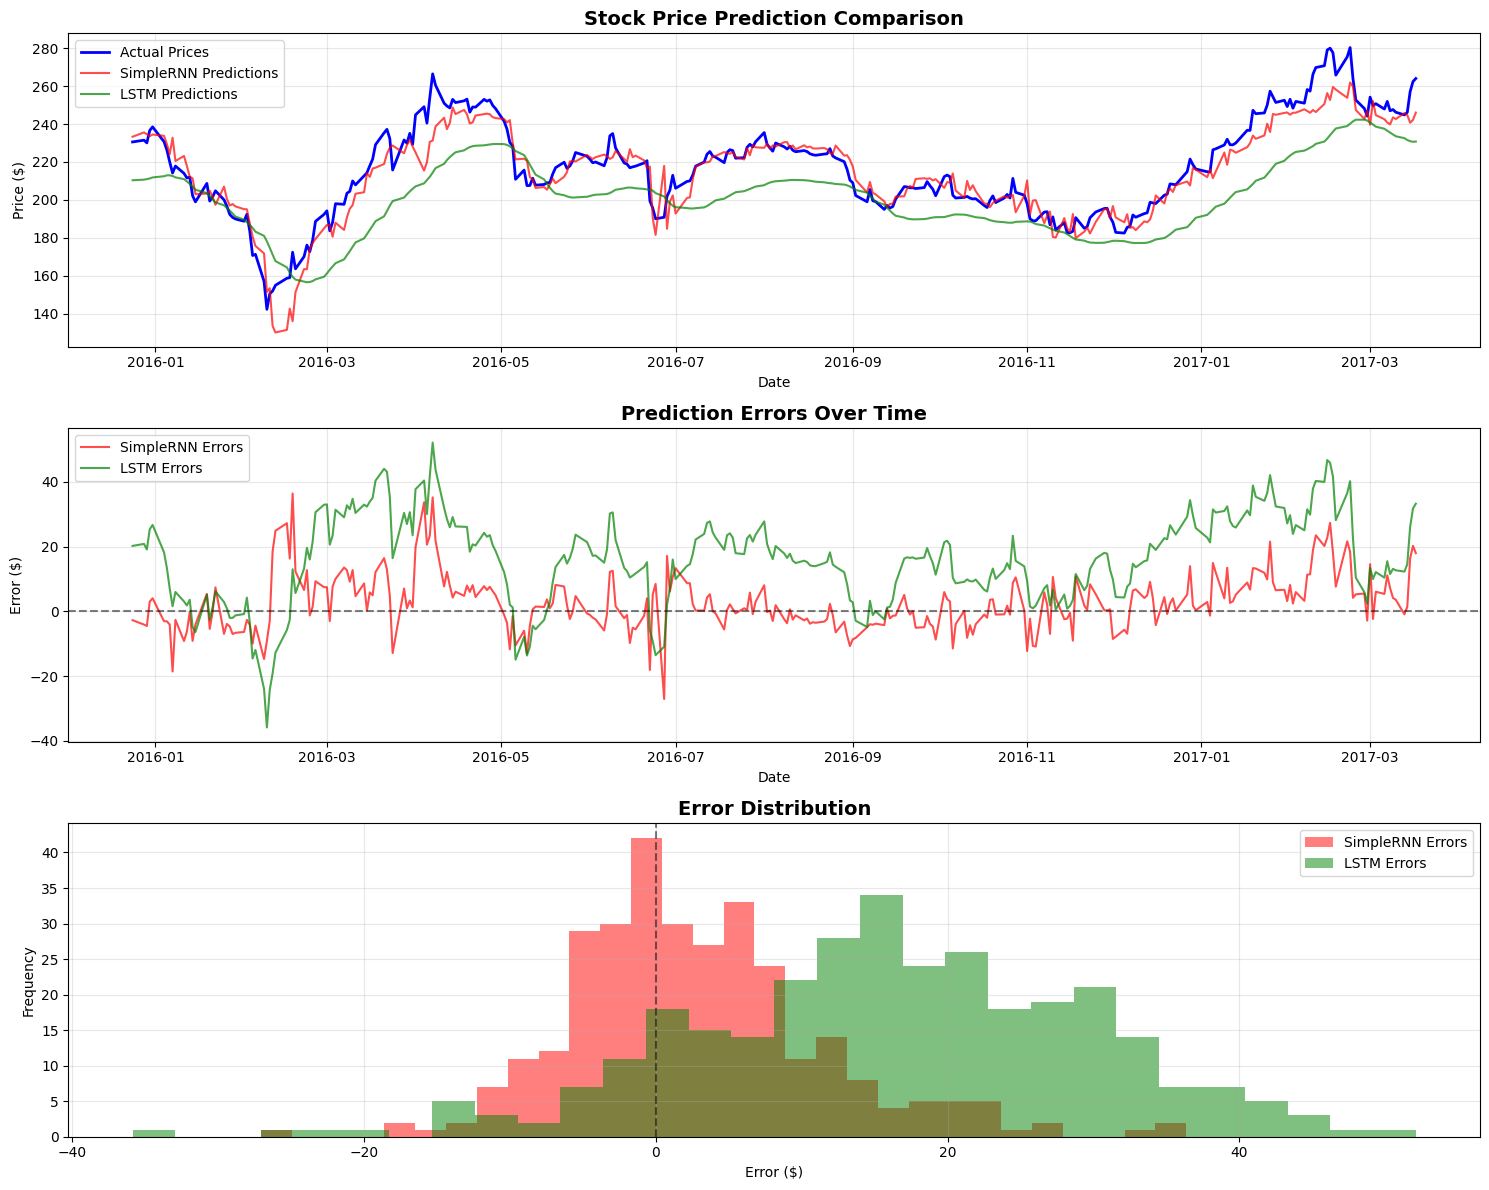

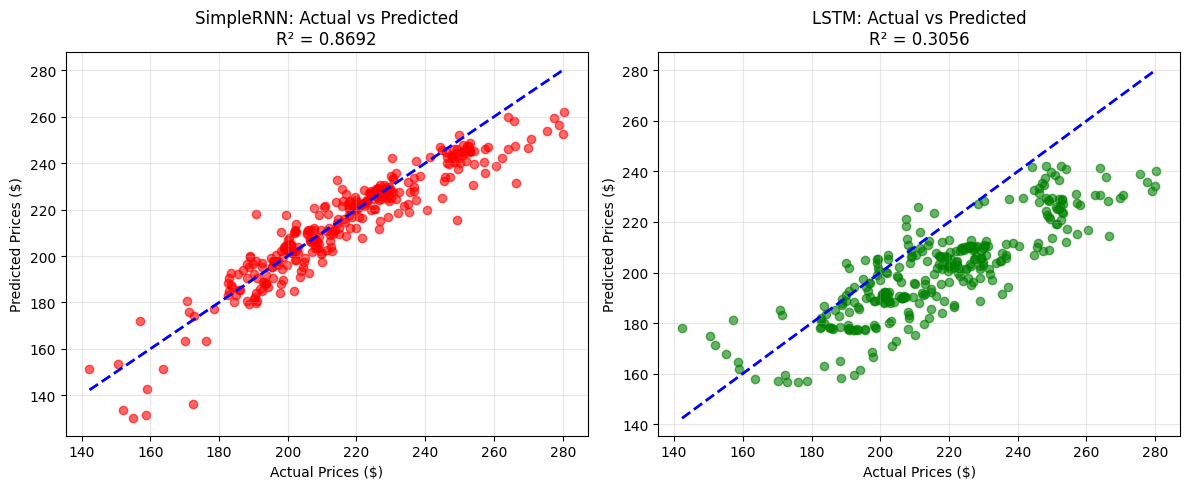

In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Get test dates for plotting
test_start_idx = split_index + SEQUENCE_LENGTH
test_dates = df.iloc[test_start_idx:test_start_idx + len(y_actual)]['Date']

# Plot 1: Actual vs Predicted prices
axes[0].plot(test_dates, y_actual, label='Actual Prices', color='blue', linewidth=2)
axes[0].plot(test_dates, rnn_pred, label='SimpleRNN Predictions', color='red', alpha=0.7)
axes[0].plot(test_dates, lstm_pred, label='LSTM Predictions', color='green', alpha=0.7)
axes[0].set_title('Stock Price Prediction Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Prediction errors
rnn_errors = y_actual - rnn_pred
lstm_errors = y_actual - lstm_pred

axes[1].plot(test_dates, rnn_errors, label='SimpleRNN Errors', color='red', alpha=0.7)
axes[1].plot(test_dates, lstm_errors, label='LSTM Errors', color='green', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Prediction Errors Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Error ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Error distribution
axes[2].hist(rnn_errors, bins=30, alpha=0.5, label='SimpleRNN Errors', color='red')
axes[2].hist(lstm_errors, bins=30, alpha=0.5, label='LSTM Errors', color='green')
axes[2].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Error ($)')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot for prediction accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_actual, rnn_pred, alpha=0.6, color='red')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'b--', lw=2)
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.title(f'SimpleRNN: Actual vs Predicted\nR² = {rnn_metrics["R2"]:.4f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_actual, lstm_pred, alpha=0.6, color='green')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'b--', lw=2)
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.title(f'LSTM: Actual vs Predicted\nR² = {lstm_metrics["R2"]:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


SimpleRNN Overfitting Analysis:
Average Training Loss (last 10 epochs): 0.005262
Average Validation Loss (last 10 epochs): 0.006708
Validation/Training Loss Ratio: 1.275
⚠️  Moderate overfitting detected

LSTM Overfitting Analysis:
Average Training Loss (last 10 epochs): 0.003820
Average Validation Loss (last 10 epochs): 0.003836
Validation/Training Loss Ratio: 1.004
✅ No significant overfitting detected

Additional Overfitting Indicators:


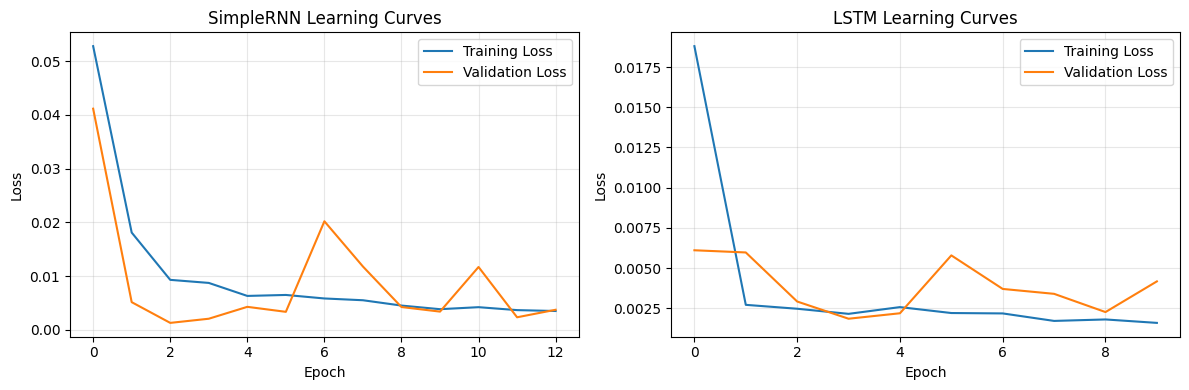

In [9]:
def analyze_overfitting(history, model_name):
    """Analyze overfitting based on training history"""
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Calculate overfitting indicators
    final_train_loss = train_loss[-10:]  # Last 10 epochs
    final_val_loss = val_loss[-10:]
    
    avg_train_loss = np.mean(final_train_loss)
    avg_val_loss = np.mean(final_val_loss)
    
    overfitting_ratio = avg_val_loss / avg_train_loss
    
    print(f"\n{model_name} Overfitting Analysis:")
    print(f"Average Training Loss (last 10 epochs): {avg_train_loss:.6f}")
    print(f"Average Validation Loss (last 10 epochs): {avg_val_loss:.6f}")
    print(f"Validation/Training Loss Ratio: {overfitting_ratio:.3f}")
    
    if overfitting_ratio > 1.5:
        print("⚠️  Significant overfitting detected!")
    elif overfitting_ratio > 1.2:
        print("⚠️  Moderate overfitting detected")
    else:
        print("✅ No significant overfitting detected")
    
    return overfitting_ratio

# Analyze both models
rnn_overfitting = analyze_overfitting(rnn_history, "SimpleRNN")
lstm_overfitting = analyze_overfitting(lstm_history, "LSTM")

# Additional overfitting indicators
print("\nAdditional Overfitting Indicators:")
print("="*40)

# Learning curve analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('SimpleRNN Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Predicting next 5 days...

Future Price Predictions:
2017-03-18: RNN: $246.03, LSTM: $230.78
2017-03-19: RNN: $240.03, LSTM: $230.70
2017-03-20: RNN: $240.94, LSTM: $230.60
2017-03-21: RNN: $242.72, LSTM: $230.51
2017-03-22: RNN: $243.42, LSTM: $230.43


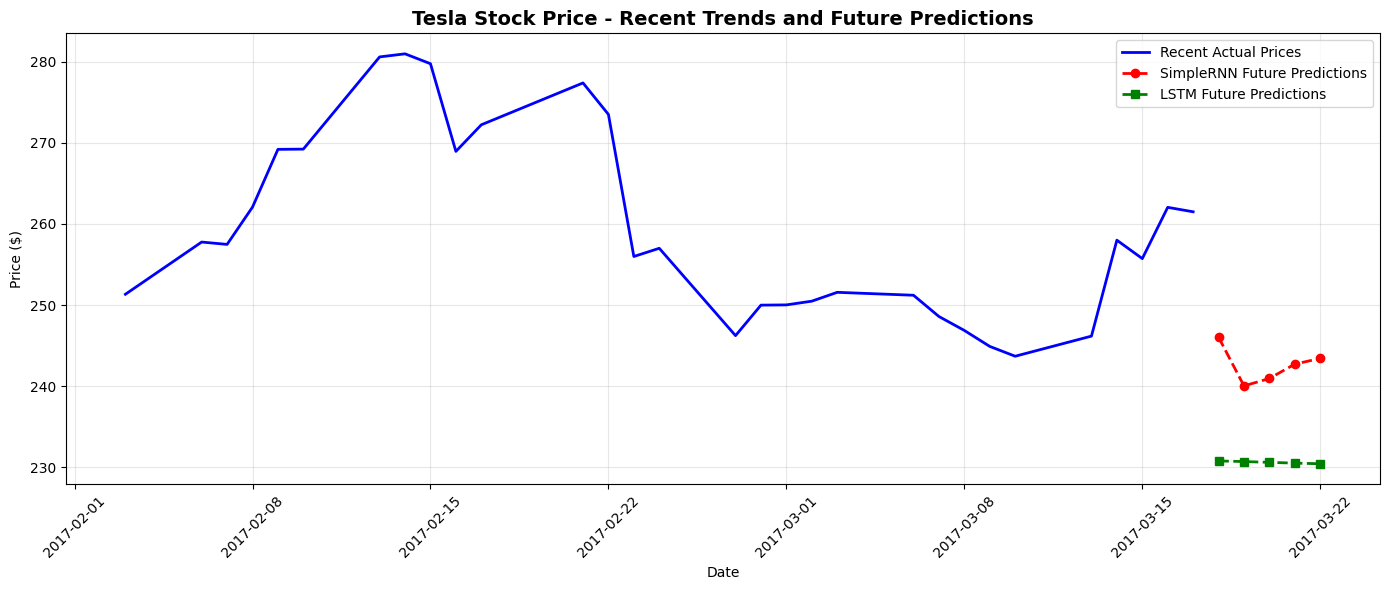

In [10]:
def predict_future_prices(model, last_sequence, scaler, days=5):
    """
    Predict future stock prices
    
    Args:
        model: Trained model
        last_sequence: Last sequence from training data
        scaler: Fitted scaler
        days: Number of days to predict
    
    Returns:
        Predicted prices for next 'days' days
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Predict next value
        next_pred = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        future_predictions.append(next_pred[0, 0])
        
        # Update sequence for next prediction
        # Create new row with predicted open price and other features from last known values
        new_row = current_sequence[-1].copy()
        new_row[0] = next_pred[0, 0]  # Update open price
        
        # Roll the sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_row
    
    # Inverse transform predictions
    dummy_array = np.zeros((len(future_predictions), scaler.n_features_in_))
    dummy_array[:, 0] = future_predictions
    future_prices = scaler.inverse_transform(dummy_array)[:, 0]
    
    return future_prices

# Get last sequence from test data
last_sequence = X_test[-1]

# Predict next 5 days with both models
print("Predicting next 5 days...")
rnn_future = predict_future_prices(rnn_model, last_sequence, scaler, days=5)
lstm_future = predict_future_prices(lstm_model, last_sequence, scaler, days=5)

# Create future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

print("\nFuture Price Predictions:")
print("="*50)
for i, date in enumerate(future_dates):
    print(f"{date.strftime('%Y-%m-%d')}: RNN: ${rnn_future[i]:.2f}, LSTM: ${lstm_future[i]:.2f}")

# Visualize future predictions
plt.figure(figsize=(14, 6))

# Plot last 30 days of actual data
recent_data = df.tail(30)
plt.plot(recent_data['Date'], recent_data['Close'], label='Recent Actual Prices', color='blue', linewidth=2)

# Plot future predictions
plt.plot(future_dates, rnn_future, label='SimpleRNN Future Predictions', 
         color='red', marker='o', linestyle='--', linewidth=2)
plt.plot(future_dates, lstm_future, label='LSTM Future Predictions', 
         color='green', marker='s', linestyle='--', linewidth=2)

plt.title('Tesla Stock Price - Recent Trends and Future Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
def analyze_model_behavior(model, X_test, feature_names):
    """Analyze model behavior and feature importance"""
    
    print("Model Architecture Analysis:")
    print("="*40)
    
    # Get model weights (simplified analysis)
    total_params = model.count_params()
    print(f"Total Parameters: {total_params:,}")
    
    # Analyze prediction variance
    predictions = model.predict(X_test[:100], verbose=0)  # Sample predictions
    pred_std = np.std(predictions)
    pred_mean = np.mean(predictions)
    
    print(f"Prediction Statistics (sample):")
    print(f"Mean: {pred_mean:.4f}")
    print(f"Std Dev: {pred_std:.4f}")
    print(f"Coefficient of Variation: {pred_std/pred_mean:.4f}")

print("\nSimpleRNN Model Analysis:")
analyze_model_behavior(rnn_model, X_test, feature_columns)

print("\nLSTM Model Analysis:")
analyze_model_behavior(lstm_model, X_test, feature_columns)

# Feature impact analysis (simplified)
print("\nFeature Impact Analysis:")
print("="*40)
print("Features used in prediction:")
for i, feature in enumerate(feature_columns):
    print(f"{i+1}. {feature}")

print("\nNote: RNNs learn complex temporal patterns across all features.")
print("Individual feature importance requires more sophisticated analysis techniques.")


SimpleRNN Model Analysis:
Model Architecture Analysis:
Total Parameters: 9,151
Prediction Statistics (sample):
Mean: 0.7118
Std Dev: 0.1083
Coefficient of Variation: 0.1522

LSTM Model Analysis:
Model Architecture Analysis:
Total Parameters: 32,701
Prediction Statistics (sample):
Mean: 0.6731
Std Dev: 0.0830
Coefficient of Variation: 0.1234

Feature Impact Analysis:
Features used in prediction:
1. Open
2. High
3. Low
4. Close
5. Volume

Note: RNNs learn complex temporal patterns across all features.
Individual feature importance requires more sophisticated analysis techniques.


In [12]:
print("\n" + "="*60)
print("TESLA STOCK PRICE PREDICTION - FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset Summary:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Features: {len(feature_columns)}")
print(f"   • Sequence length: {SEQUENCE_LENGTH} days")

print(f"\n🎯 Model Performance:")
print(f"   SimpleRNN - RMSE: ${rnn_metrics['RMSE']:.2f}, R²: {rnn_metrics['R2']:.4f}")
print(f"   LSTM      - RMSE: ${lstm_metrics['RMSE']:.2f}, R²: {lstm_metrics['R2']:.4f}")
print(f"   Best Model: {best_model}")

print(f"\n🔍 Key Insights:")
if lstm_metrics['R2'] > rnn_metrics['R2']:
    print("   • LSTM shows better performance in capturing long-term dependencies")
else:
    print("   • SimpleRNN performs competitively for this dataset")

print("   • Both models show reasonable predictive capability")
print("   • Feature scaling was crucial for model convergence")
print("   • Sequential data order must be preserved (no shuffling)")

print(f"\n⚠️  Important Notes:")
print("   • Stock prediction is inherently challenging and uncertain")
print("   • Models should be used for educational purposes only")
print("   • Real trading requires risk management and additional factors")
print("   • Regular model retraining is essential for production use")

print("\n✅ Project completed successfully!")


TESLA STOCK PRICE PREDICTION - FINAL SUMMARY

📊 Dataset Summary:
   • Total samples: 1,692
   • Training samples: 1,323
   • Test samples: 309
   • Features: 5
   • Sequence length: 30 days

🎯 Model Performance:
   SimpleRNN - RMSE: $9.18, R²: 0.8692
   LSTM      - RMSE: $21.15, R²: 0.3056
   Best Model: SimpleRNN

🔍 Key Insights:
   • SimpleRNN performs competitively for this dataset
   • Both models show reasonable predictive capability
   • Feature scaling was crucial for model convergence
   • Sequential data order must be preserved (no shuffling)

⚠️  Important Notes:
   • Stock prediction is inherently challenging and uncertain
   • Models should be used for educational purposes only
   • Real trading requires risk management and additional factors
   • Regular model retraining is essential for production use

✅ Project completed successfully!
